In [1]:
import glob
from collections import Counter

import skimage.io as io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from albumentations import PadIfNeeded, VerticalFlip, HorizontalFlip, RandomRotate90, Transpose, Compose

In [2]:
frames = glob.glob('/root/data/phytoplankton/raw/*/*/*.jpg')
print("Total number of frames: {}".format(len(frames)))

Total number of frames: 155349


In [3]:
cter = Counter([f.split('/')[-2] for f in frames]).most_common()

In [4]:
# at least 100 images
classes =[c[0] for c in cter if c[1] > 100]
nclasses = len(classes)
classes_counter = {c[0]: c[1] for c in cter}
print('Numer of classes {}'.format(nclasses))

Numer of classes 55


In [5]:
train_class_dict = {}
val_class_dict = {}
for f in frames:
    cl = f.split('/')[-2]
    if cl not in train_class_dict:
        train_class_dict[cl] = []
        val_class_dict[cl] = []
    if len(train_class_dict[cl]) > 0.85*classes_counter[cl]:
        val_class_dict[cl].append(f)
    else:
        train_class_dict[cl].append(f)

In [6]:
input_size = (64, 64, 3)
batch_size = 32

In [7]:
aug = Compose([PadIfNeeded(p=1, min_height=input_size[0], min_width=input_size[1], border_mode=0),
               VerticalFlip(p=0.3),
               HorizontalFlip(p=0.3),
               RandomRotate90(p=0.3),
               Transpose(p=0.3)])

In [8]:
def generator(class_dict, batch_size, input_size):
    while True:
        xb = np.zeros((batch_size, input_size[0], input_size[1], input_size[2]))
        yb = np.zeros((batch_size, nclasses))
        i = 0
        while i < batch_size:
            rclass = np.random.choice(classes)
            rpath = np.random.choice(class_dict[rclass])
            image = io.imread(rpath)
            
            try:
                # remove black
                imgsum = np.sum(image, axis=2)
                ind0 = np.where(np.sum(imgsum, axis=1) < 5000)[0]
                ind1 = np.where(np.sum(imgsum, axis=0) < 5000)[0]
                if len(ind0) > 0 and len(ind1) >0:
                    new_im = image[:ind0.min(), :ind1.min(), :]
                elif len(ind0) > 0 and len(ind1) == 0:
                    new_im = image[:ind0.min(), :, :]
                elif len(ind0) == 0 and len(ind1) > 0:
                    new_im = image[:, :ind1.min(), :]
                else:
                    new_im = image
                # print(new_im.shape)
                augmented = aug(image=new_im)["image"]
                new_im = augmented
                rimage = resize(new_im, input_size)
                # rimage = resize(image, input_size)
                xb[i, ...] = rimage
                yb[i, classes.index(rclass)] = 1
                i += 1
            except:
                print('problem')
        yield xb, yb

In [9]:
train_gen = generator(train_class_dict, batch_size, input_size)
val_gen = generator(val_class_dict, batch_size, input_size)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


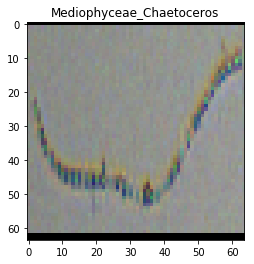

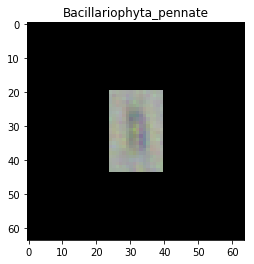

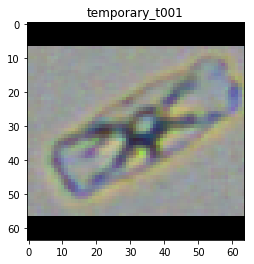

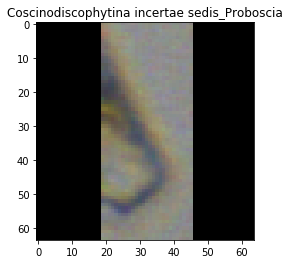

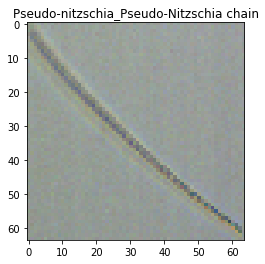

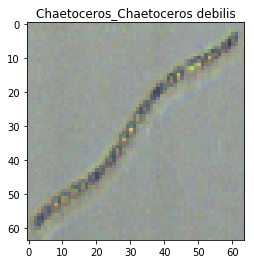

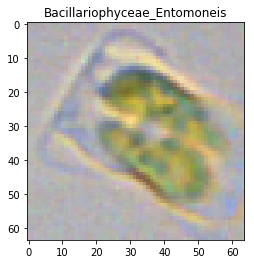

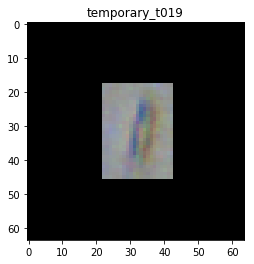

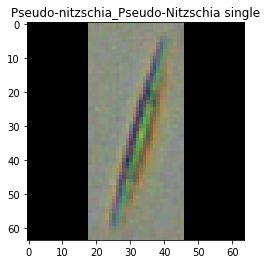

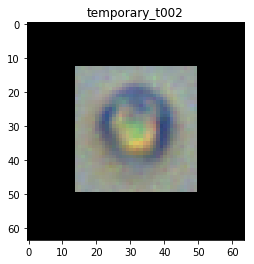

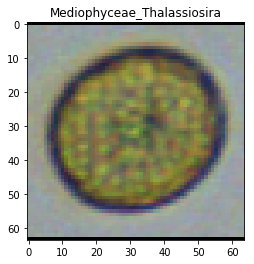

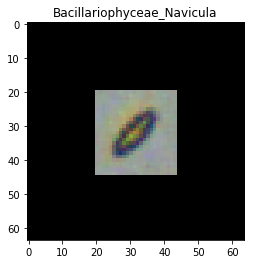

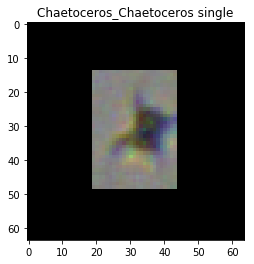

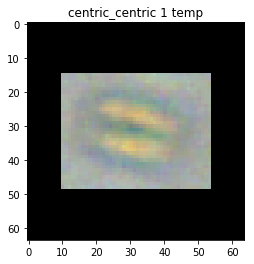

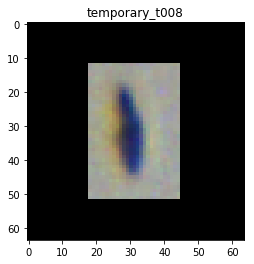

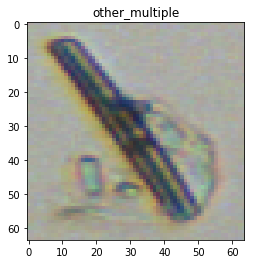

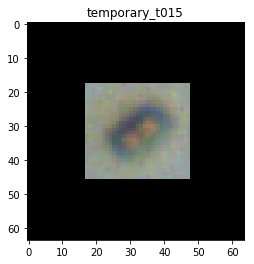

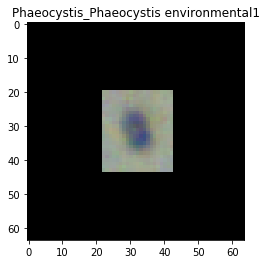

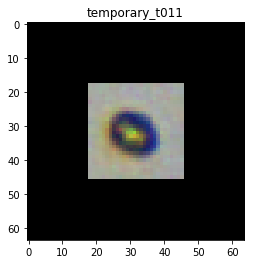

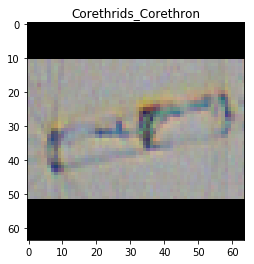

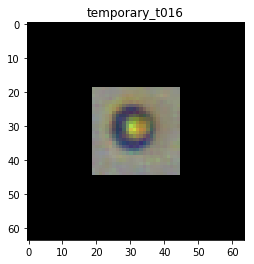

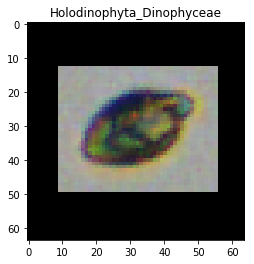

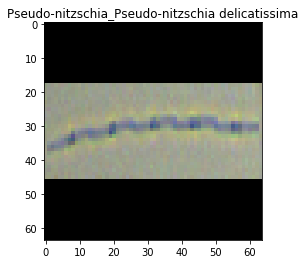

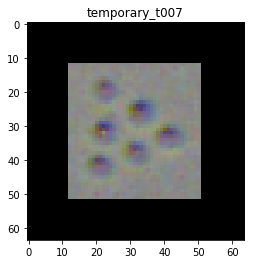

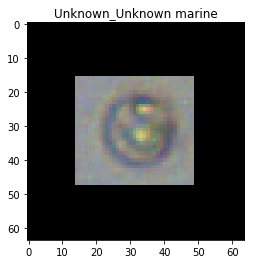

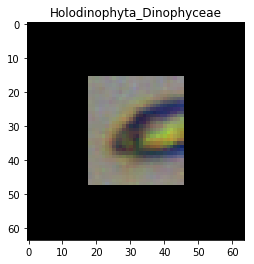

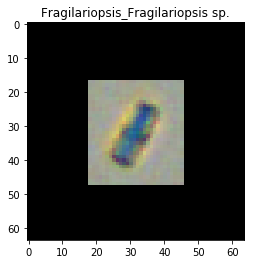

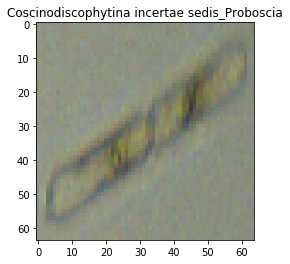

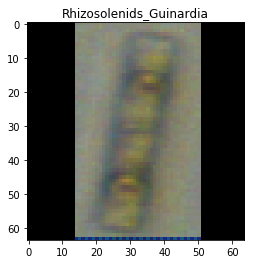

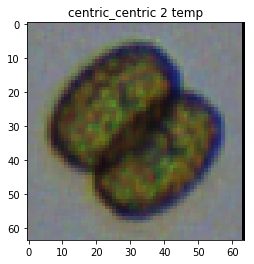

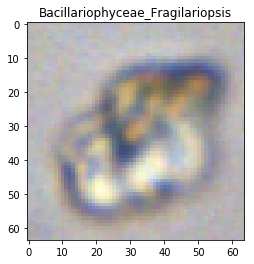

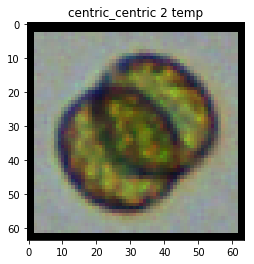

In [10]:
xb, yb = next(train_gen)
for i in range(batch_size):
    plt.imshow(xb[i, ...])
    plt.title(classes[np.argmax(yb[i, ...])])
    plt.show()

# create model

In [11]:
import keras
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50
from keras import layers
from keras.models import Model

Using TensorFlow backend.


In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_size))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(nclasses, activation='softmax'))

In [14]:
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

In [15]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=input_size)
x = layers.GlobalAveragePooling2D(name='avg_pool')(resnet50.output)
x = layers.Dense(nclasses, activation='softmax', name='fc1000')(x)
model = Model(inputs=[resnet50.input], outputs=[x])
model.compile("adam", loss="categorical_crossentropy", metrics=['categorical_accuracy', "top_k_categorical_accuracy"])

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
model.fit_generator(train_gen,
                    steps_per_epoch=500,
                    validation_data=val_gen,
                  validation_steps=100,
                    epochs=20)

Epoch 1/20


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


500/500 [==============================] - 65s 130ms/step - loss: 3.1258 - categorical_accuracy: 0.2644 - top_k_categorical_accuracy: 0.5997 - val_loss: 5.3888 - val_categorical_accuracy: 0.1837 - val_top_k_categorical_accuracy: 0.6309
Epoch 2/20
500/500 [==============================] - 57s 114ms/step - loss: 2.1968 - categorical_accuracy: 0.4006 - top_k_categorical_accuracy: 0.7641 - val_loss: 2.6497 - val_categorical_accuracy: 0.3266 - val_top_k_categorical_accuracy: 0.6763
Epoch 3/20
500/500 [==============================] - 57s 115ms/step - loss: 1.6010 - categorical_accuracy: 0.5208 - top_k_categorical_accuracy: 0.8609 - val_loss: 3.3892 - val_categorical_accuracy: 0.2616 - val_top_k_categorical_accuracy: 0.5516
Epoch 4/20
500/500 [==============================] - 57s 115ms/step - loss: 1.4300 - categorical_accuracy: 0.5677 - top_k_categorical_accuracy: 0.8835 - val_loss: 2.3706 - val_categorical_accuracy: 0.4169 - val_top_k_categorical_accuracy: 0.7366
Epoch 5/20
500/500 [===

In [ ]:
# model.save("/root/data/phytoplankton/models/model_v0.h5")